# TASK 1. PROJECT OVERVIEW & KEY LEARNING OBJECTIVES

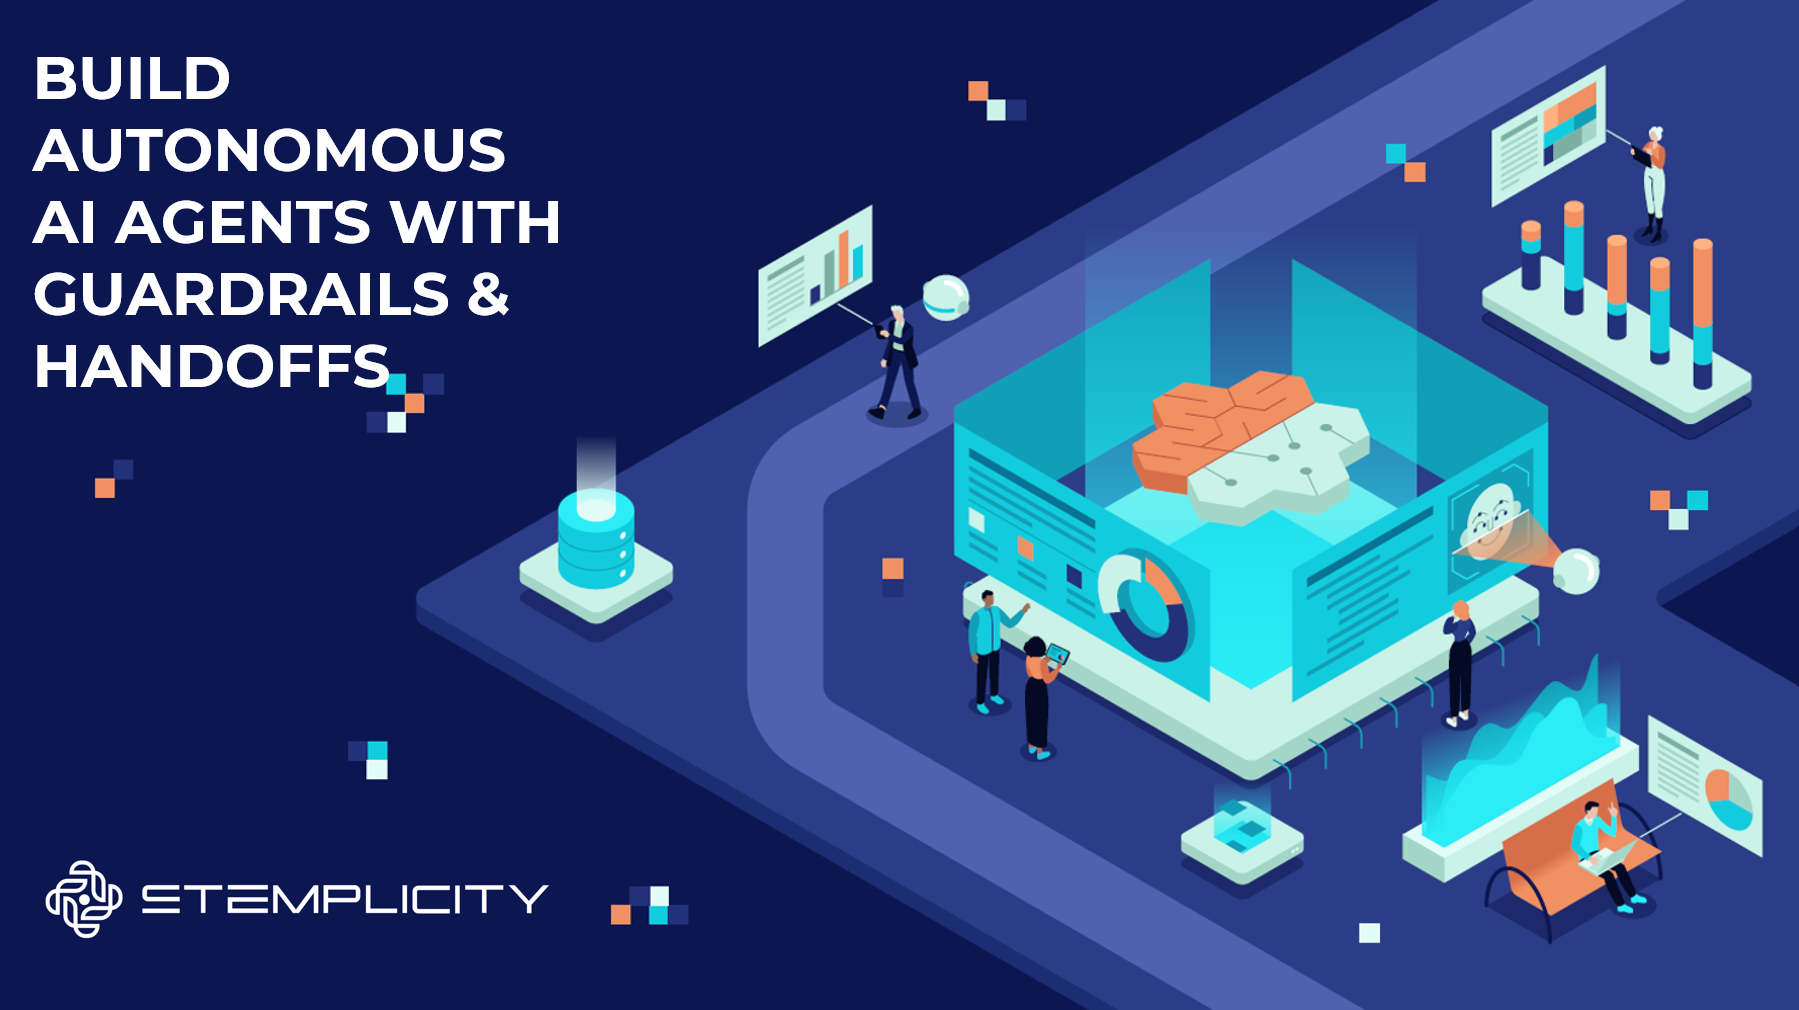

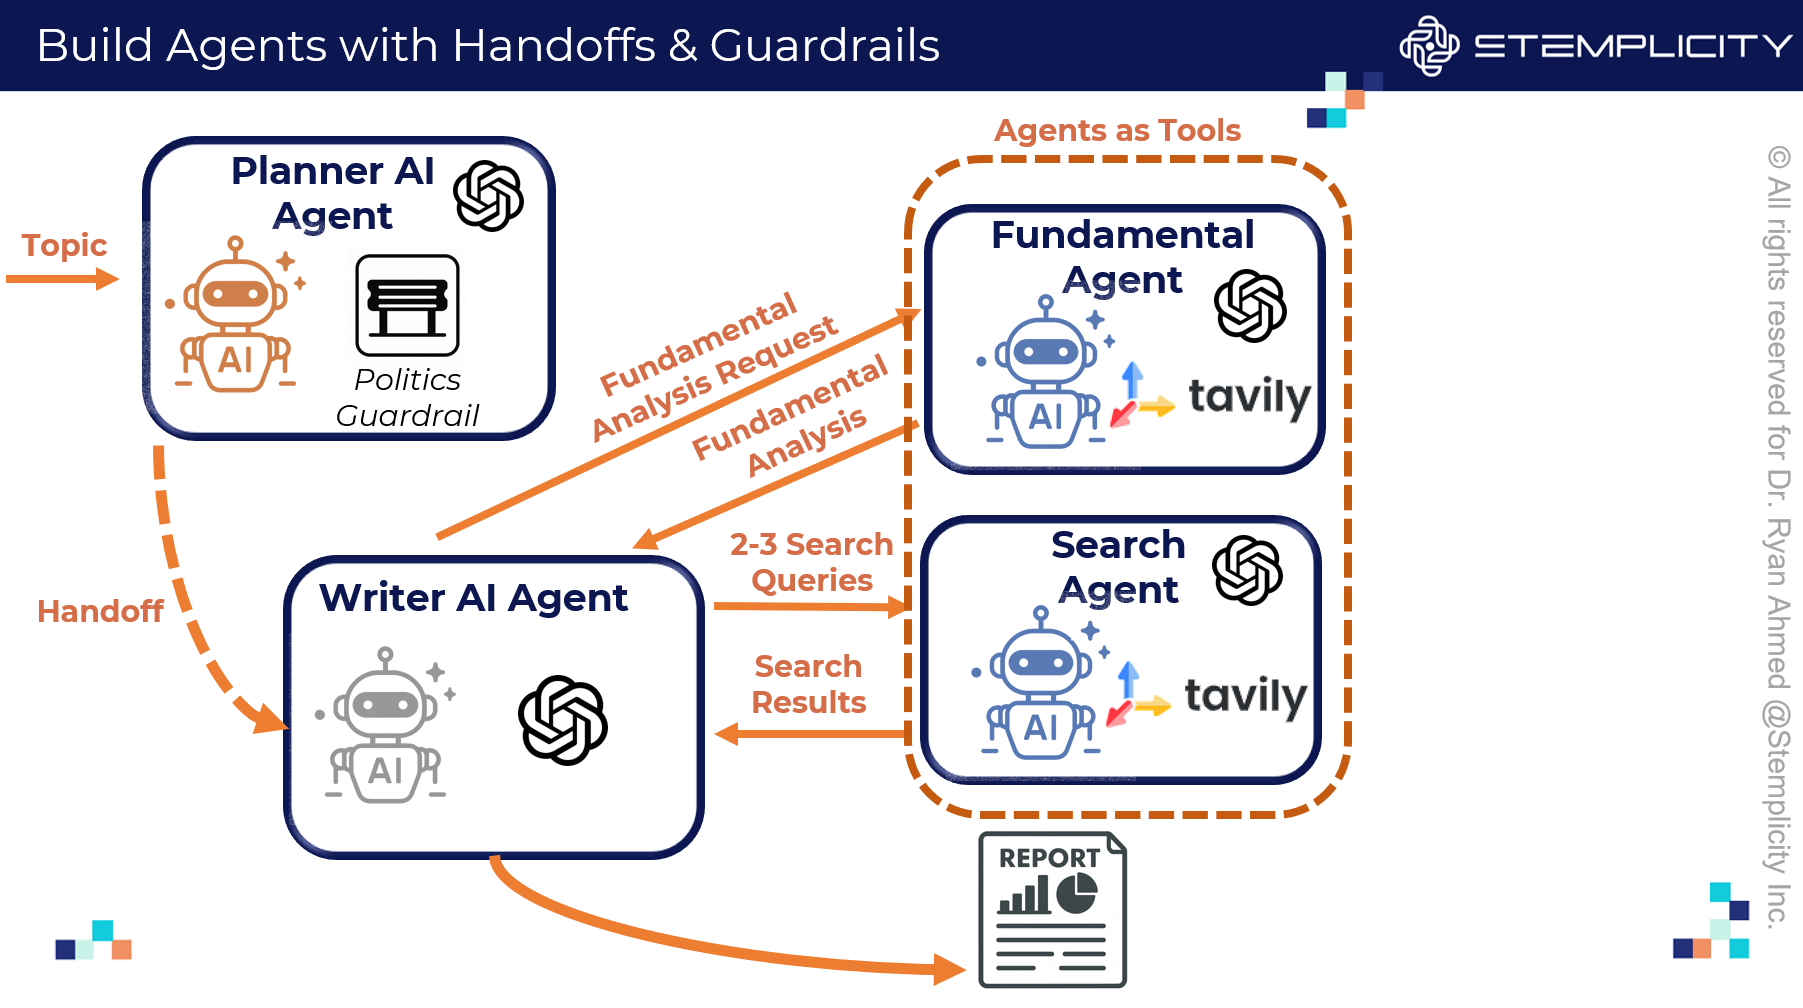

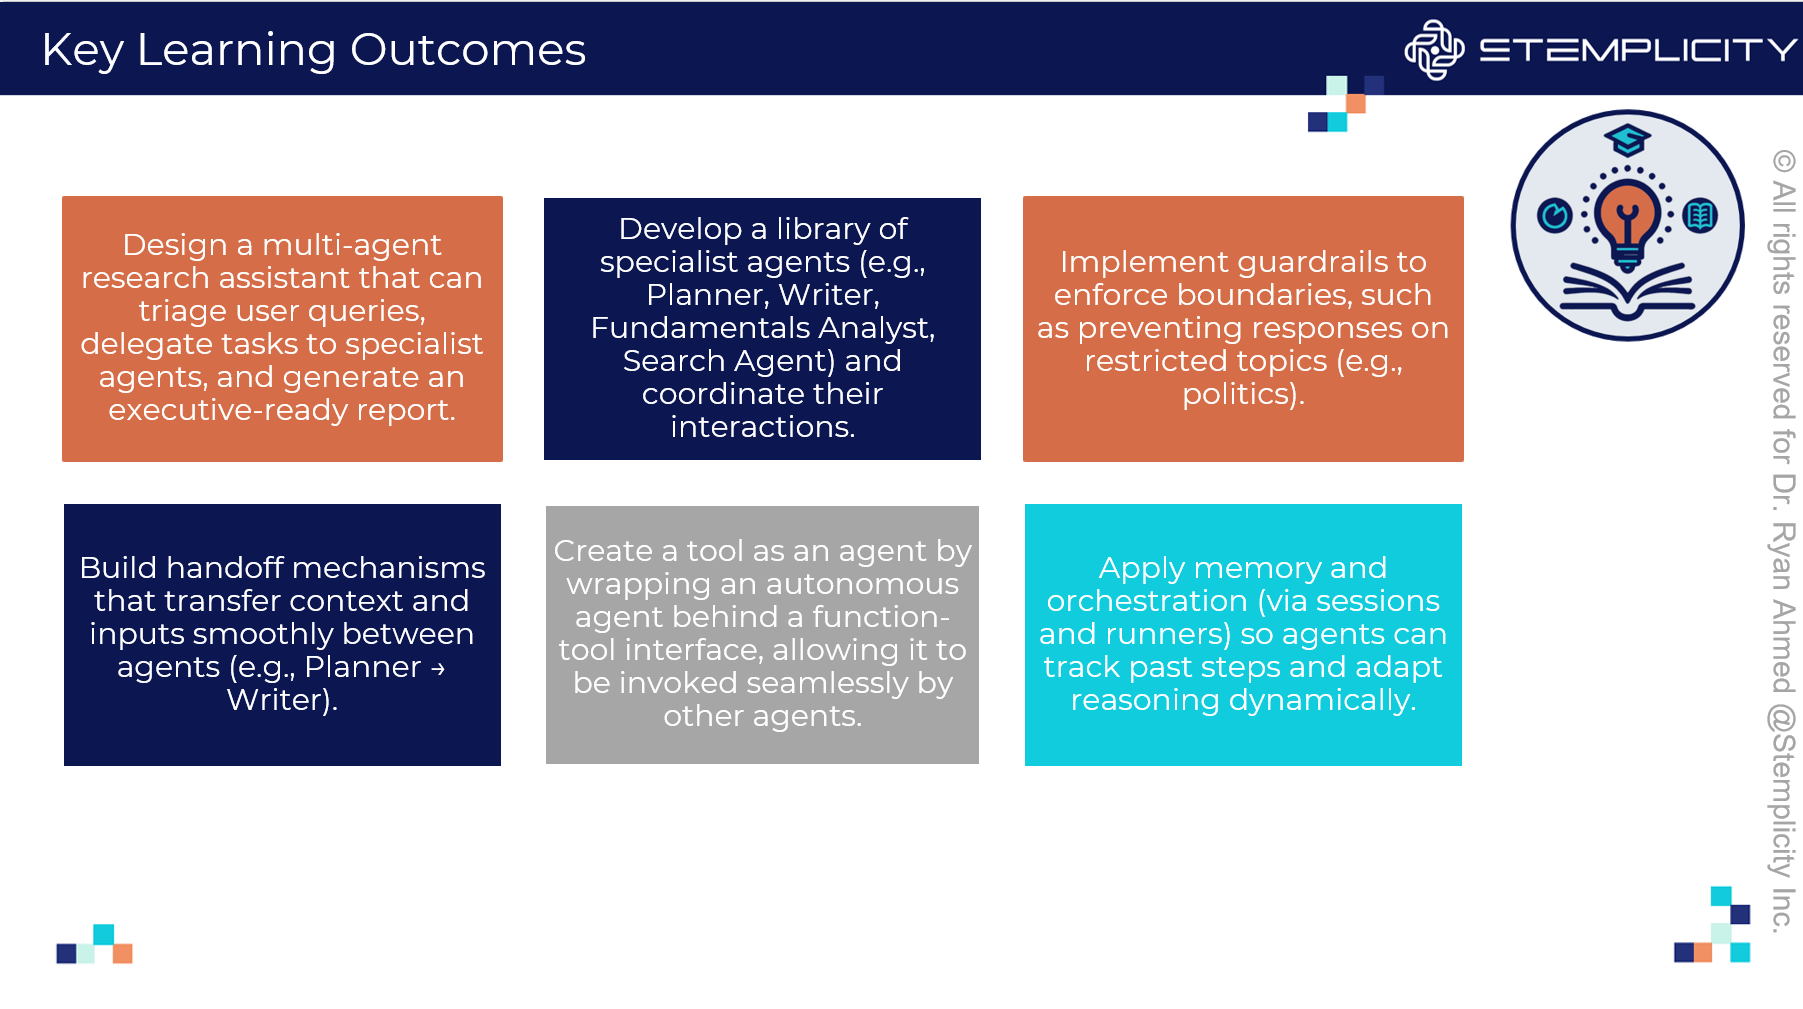

# TASK 2. SETUP API KEYS & TOOLS

In [ ]:
# !pip install -q --upgrade openai-agents==0.2.2 "rich<14.0.0,>=13.7.0" python-dotenv requests pydantic
!pip install -q --upgrade openai-agents==0.2.2 

# Install the "helper" package from PyPI so it can be used in this notebook
!pip install helper

In [ ]:
import os, requests, asyncio
from IPython.display import display, Markdown
from dotenv import load_dotenv
from agents import Agent, Runner, function_tool, SQLiteSession
from pydantic import BaseModel
from typing_extensions import TypedDict
from datetime import datetime
from agents import RunResult  # Make sure RunResult is imported
# from helper import format_report_to_markdown
from agents import handoff, RunContextWrapper, CodeInterpreterTool, input_guardrail, GuardrailFunctionOutput, TResponseInputItem
from agents.extensions import handoff_filters
from agents.extensions.handoff_prompt import RECOMMENDED_PROMPT_PREFIX

load_dotenv()
openai_api_key = os.getenv("OPENAI_API_KEY")
tavily_api_key = os.getenv("TAVILY_API_KEY")

print("✅ API keys loaded")
print(f"OpenAI: {openai_api_key[:5]}***")
print(f"Tavily: {tavily_api_key[:5]}***")

In [ ]:
def print_markdown(txt: str):
    display(Markdown(txt))

In [ ]:
# Define the models that we want to use
main_model = "gpt-4.1-mini"
small_model = "gpt-4.1-nano"

In [ ]:
# Define the Tavily search function
class TavilyParams(TypedDict):
    query: str
    max_results: int


@function_tool
def tavily_search(params: TavilyParams) -> str:
    """Return a newline‑joined summary of Tavily results."""
    url = "https://api.tavily.com/search"
    payload = {
        "api_key": tavily_api_key,
        "query": params["query"],
        "max_results": params.get("max_results", 3),
    }
    resp = requests.post(url, json = payload, headers = {"Content-Type": "application/json"})
    if resp.status_code != 200:
        return f"Tavily error {resp.status_code}"
    items = resp.json().get("results", [])
    return "\n".join([f"- {itm['title']}: {itm['content']}" for itm in items]) or "No hits"

# TASK 3. DEFINE AN AI AGENT (PLANNER) WITH GUARDRAIL

In [ ]:
# We will define a Planner Agent that breaks down user research requests into 2-3 targeted web searches with reasons and queries

# This section defines a guardrail to prevent the agent from engaging in political topics. 
# It uses a dedicated LLM agent to classify the input as political or not, and triggers a tripwire if political content is detected.

# Define the output schema for the political topic guardrail.
# Whenever we classify something as political, we’ll store two fields:
# (1) is_political: a boolean flag (True/False).
# (2) reasoning: text explaining why.
# This makes the guardrail’s output predictable and structured.

class PoliticalTopicOutput(BaseModel):
    is_political: bool
    reasoning: str


# This builds an Agent (from the OpenAI Agents SDK) to detect political content.
# The instructions tell the model exactly what to do.
# The output_type enforces that the agent must return a PoliticalTopicOutput.

politics_guardrail_agent = Agent(name = "Guardrail check",
                                 instructions = "Check if the user is asking about political topics, politicians, elections, government policy, or anything related to politics. If so, set is_political to true and explain why in reasoning.",
    output_type = PoliticalTopicOutput)


# @input_guardrail: decorator that marks the function 
# The function takes:
# ctx: a wrapper object holding context/state for the current run (things like conversation history, metadata, or session info).
# input: what the user typed in (either a string, or a structured list of TResponseInputItem).
# The function returns a GuardrailFunctionOutput: what did we find, and do we trip the guardrail?


@input_guardrail
async def politics_guardrail(ctx: RunContextWrapper[None], agent: Agent, input: str | list[TResponseInputItem]) -> GuardrailFunctionOutput:
    
    # Use the guardrail agent to classify the input.
    result = await Runner.run(politics_guardrail_agent, input, context = ctx.context)

    # output_info: stores the full structured output (is_political + reasoning).
    # tripwire_triggered: this is the key flag. If is_political == True, then the guardrail has been triggered.
    return GuardrailFunctionOutput(output_info = result.final_output,
                                   tripwire_triggered = result.final_output.is_political)

In [ ]:
# Define a data model for one search plan item where each item contains:
# - reason: why this particular search is being done
# - query: the actual search string to run

class SearchPlanItem(BaseModel):
    reason: str
    query: str

# Define a data model for the complete search plan
# This contains a list of SearchPlanItems

class SearchPlan(BaseModel):
    searches: list[SearchPlanItem]

# Get today's date in YYYY-MM-DD format
date = datetime.now().strftime("%Y-%m-%d")

# Create an AI agent called "Planner"
planner_agent = Agent(name = "Planner",
                      instructions = f"""Current date: {date} \n Context: You are a research planner agent tasked with designing a comprehensive research plan for a user request. 
        You have access to web search tools and should utilize the current date ({date}) when planning. 
        Instruction: Break down the user's request into 3 distinct web searches, each with a clear reason and a specific query. 
        Ensure coverage of recent news, company fundamentals, risks, sentiment, and broader context. 
        Input: The user's research request and the current date. 
        Output: A list of search plan items, each with a 'reason' and a 'query', formatted as a JSON object matching the SearchPlan schema.""",
    model = main_model,
    output_type = SearchPlan,
    input_guardrails = [politics_guardrail]) # THIS IS THE GUARDRAIL THAT PREVENTS POLITICAL TOPIC ASKS

In [ ]:
# Let's test the AI Agent with the Guardrail!
from agents import Runner
q1 = "Why is Trump meeting with Putin this week?"
# q1 = "solid state battery companies"
run1 = await Runner.run(starting_agent = planner_agent, input = q1)
print_markdown(f"### 🤖 Agent’s Answer\n{run1.final_output}")

**PRACTICE OPPORTUNITY:**
- **Create a new guardrail that will block the agent from discussing topics related to defence and military.**
  - **Update the guardrail agent's instructions so that it focuses on analyzing defence and military-related issues and risks.**
  - **Instantiate the `defense_guardrail` agent.**
  - **Provide an example input (e.g., "Lockheed Martin drones") and test the agent.**

# TASK 4. DEFINE A TEAM OF AI AGENTS:  SEARCH & FUNDAMENTAL ANALYSIS AGENTS

In [ ]:
# Let's define the Search Agent, which finds and summarizes the most recent, relevant information for a research query
class Summary(BaseModel):
    summary: str

search_agent = Agent(name = "Searcher",
                     instructions = """Context: You are a search specialist agent with access to the Tavily web search tool. 
        Your goal is to provide up-to-date, relevant information for a research task. 
        Instruction: Use Tavily search to find the most recent and pertinent information related to the user's query. 
        Summarize your findings clearly and concisely in no more than 200 words. 
        Input: The user's search query. 
        Output: A concise summary (≤200 words) of the most relevant and recent information found via Tavily search.""",
    tools = [tavily_search],
    model = main_model,
    output_type = Summary)

In [ ]:
# Let's define the fundamentals Analysis Agent

fundamentals_agent = Agent(
    name = "FundamentalsAnalyst",
    instructions = """
    Context: You are a financial analyst specializing in company fundamentals.
    Instruction: Carefully analyze the provided notes to assess the company's financial fundamentals, including revenue, growth, and margins.
    Input: Notes containing relevant financial data and qualitative information about the company.
    Output: A concise summary (≤200 words) highlighting key points about the company's revenue, growth trajectory, and profit margins.
    Tools: The following tools are available for comprehensive research on the company:
    - tavily_search: Search the web for information about the company.
    """,
    output_type = Summary,
    model = main_model,
    tools = [tavily_search])

# TASK 5: CREATE AGENTS AS TOOLS FOR THE WRITER AGENT

In [ ]:
# Let's define a writer Agent which synthesizes Search and Analyst Insights into a Cohesive Investment Report

# Define the output format for the writer agent using Pydantic's BaseModel
# This ensures the agent always returns:
# - short_summary: a brief 2–3 sentence executive summary
# - markdown_report: a detailed markdown-formatted report
# - follow_up_questions: 3–5 suggested research questions

class FinalReport(BaseModel):
    short_summary: str
    markdown_report: str
    follow_up_questions: list[str]


# Define an asynchronous helper function to extract the "summary" field
# from the final_output of another agent’s run results.
# This is used so the writer agent can easily consume outputs of other tools.

async def extract_summary(run_result: RunResult) -> str:
    """Extracts the 'summary' field from the final_output of an agent run."""
    return run_result.final_output.summary

# Define the writer agent
writer_agent = Agent(name = "Writer",
                     instructions = ("""Context: You are an expert research writer preparing a comprehensive investment report on a company, using diverse information sources. Your audience is sophisticated and expects clarity, depth, and actionable insights.
        Instruction: Thoroughly analyze the provided search snippets and analyst summaries. Synthesize these into a cohesive, well-structured markdown report of at least 600 words. Your report must: (1) begin with a concise 2-3 sentence executive summary capturing the most critical findings; (2) integrate and cross-reference key facts, trends, and perspectives from all sources, highlighting both consensus and disagreement; (3) organize content with clear headings and logical flow; (4) maintain objectivity, cite evidence, and avoid speculation; (5) conclude with 3-5 insightful, specific follow-up research questions that would meaningfully advance understanding or address unresolved issues. 
        Ensure the writing is precise, professional, and tailored for an investment decision-making context.
        You must always use the 'search' tool to gather and incorporate up-to-date information in your report. The other tools—'fundamentals'—are optional and should only be used if the user specifically requests those analyses or if you determine that including them would significantly enhance the report's quality or relevance.

        Input: A set of search snippets and analyst summaries containing relevant information about the company, and any user instructions specifying which analyses to include.
        Output: A markdown-formatted report (minimum 600 words) including an executive summary and 3-5 well-crafted follow-up research questions.
        Tools: The following tools are available for comprehensive research on the company:
        - fundamentals: Get fundamentals analysis (optional)
        - search: Get search results (required)
        """
    ),
    model = main_model,
    output_type = FinalReport,

    # Note that fundamentals_agent and search_agent are other AI agents we defined earlier.
    # The method .as_tool(...) wraps each of them into a callable tool so that the writer_agent can use them.
    # This means the writer agent is not working alone — it can “call” the search agent (required) and fundamentals agent (optional) as helper sub-agents.
        
    tools = [
        fundamentals_agent.as_tool(
            "fundamentals",
            "Get fundamentals analysis",
            custom_output_extractor = extract_summary,  # Use the async function here
        ),
        search_agent.as_tool(
            "search",
            "Get search results",
            custom_output_extractor = extract_summary,  # Use the async function here
        ),
    ],

)

In [ ]:
# Let's test the AI Agent
q1 = "Do a deep dive on the latest news in Tesla stock. I also need the fundamental analysis of the company"
run1 = await Runner.run(starting_agent = writer_agent, input = q1)
print_markdown(f"### 🤖 Agent’s Answer\n{run1.final_output}")

**PRACTICE OPPORTUNITY:**
- **Review the traces log to see which tools were used and how many times.**
- **Explain the trace hierarchy and worflow and perform a sanity check**

# TASK 6. AI AGENTS HANDOFF

In [ ]:
# Create a session to store the handoff history
session = SQLiteSession("research_agent_handoff")

In [ ]:
# Define the input schema for transferring from Planner to Writer
class PlannerToWriterInput(BaseModel):
    original_query: str  # The original user query string
    search_plan: SearchPlan  # The search plan generated by the Planner


# Callback function that runs when Planner hands off to Writer
def on_planner_to_writer(ctx: RunContextWrapper[None], input_data: PlannerToWriterInput):
    print_markdown("➡️ Transfer: Planner → Writer")  # Print a message indicating the handoff took place


# Define the actual handoff setup from Planner to Writer
handoff_to_writer = handoff(
    agent = writer_agent,                  # The target agent (Writer) that will receive the handoff
    input_type = PlannerToWriterInput,     # The type of input data expected by the Writer
    on_handoff = on_planner_to_writer,     # The callback triggered during handoff (prints the transfer message)
    tool_name_override = "transfer_to_writer",       # Custom tool name for the handoff
    tool_description_override = "Transfer to Writer with original query and search plan")  # Tool description


# Clone the Planner agent and add handoff instructions + the handoff tool
# This ensures the Planner knows how to call the Writer once the search plan is ready.
planner_with_handoff = planner_agent.clone(
    instructions=f"""{RECOMMENDED_PROMPT_PREFIX}\n\n"""
    + planner_agent.instructions
    + "\n\nWhen you have produced the SearchPlan, call the handoff tool `handoff_to_writer` with this JSON input: {{ original_query: <the user query>, search_plan: <the SearchPlan JSON> }}.\n",
    handoffs=[handoff_to_writer])  # Add the handoff to Writer


In [ ]:
"""
This is the main function that runs the handoff chain end-to-end with a sample query.
"""
async def run_handoffs_demo(user_query: str):
    print_markdown(f"## 🕵️‍♀️ User Query\n{user_query}")  # Display the user query

    # Start the chain at the Planner; it will handoff to Writer
    run_res = await Runner.run(planner_with_handoff, user_query, session = session)
    print_markdown("---")  # Separator for output

    # Check if the final output is from the Verifier and display the result
    report = run_res.final_output

    # Display (This part is correct)
    print_markdown("---")
    print_markdown(f"### 🔎 Executive Summary\n{report.short_summary}")
    print_markdown("\n\n-----------------\n\n")
    print_markdown(f"### 📄 Full Report\n{report.markdown_report}")
    print_markdown("\n\n-----------------\n\n")
    return run_res


In [ ]:
# Example usage: run the handoff chain end-to-end with a sample query
handoff_result = await run_handoffs_demo("Can you let me know about the stock holdings of people who are in congress")


In [ ]:
handoff_result = await run_handoffs_demo(
    "Do a deep dive on the latest news and developments in the AAPL stock. Also I need the fundamentals analysis of the company."
)

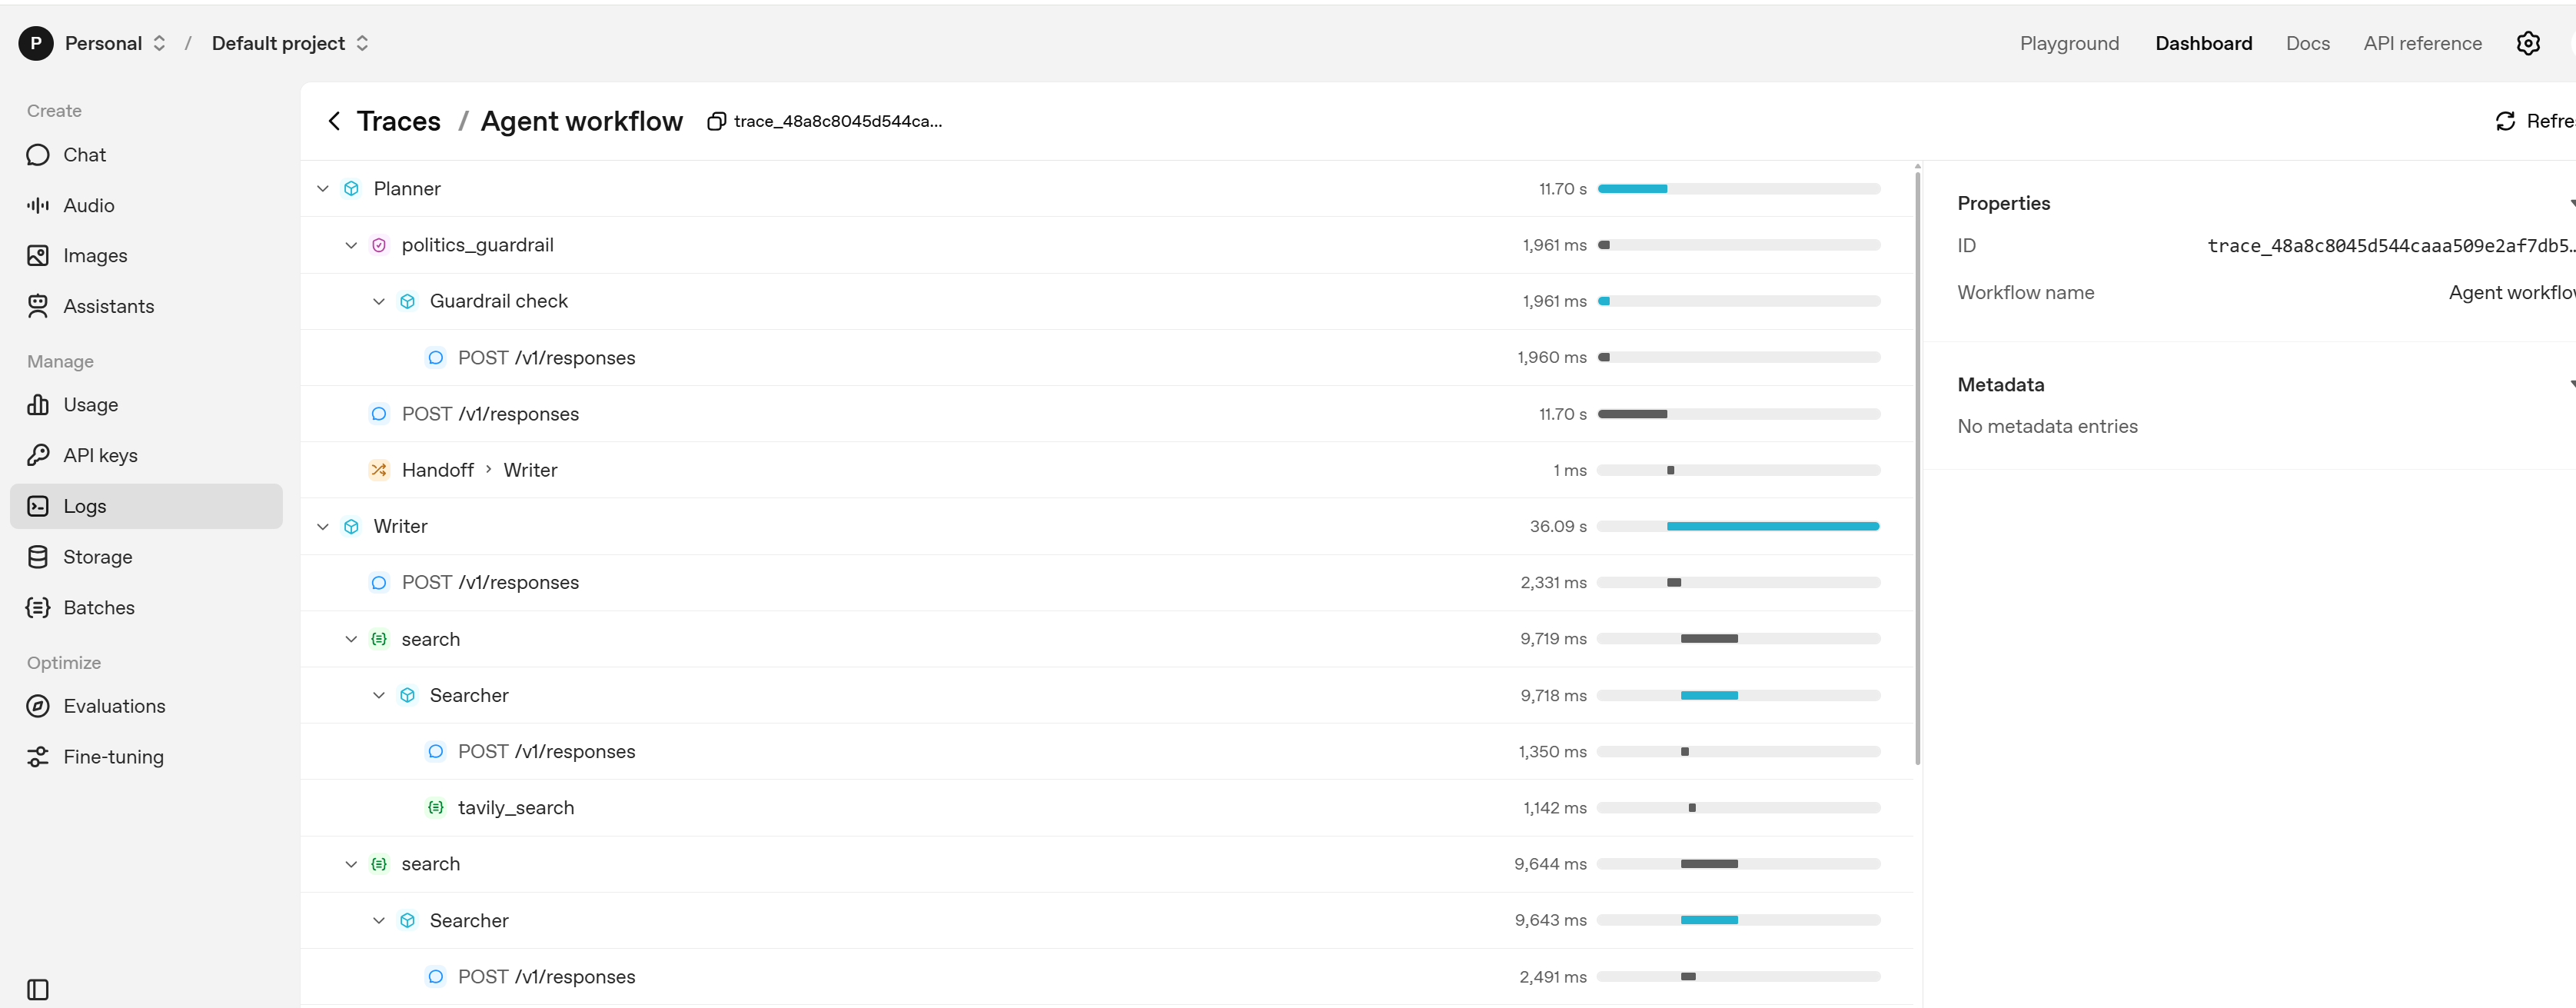

**PRACTICE OPPORTUNITY:**
- **Create a new AI agent named SentimentAgent that specializes in searching online to find out the sentiment regarding a company.**
  - **Update the agent's instructions so that it focuses on analyzing online sentiment (positive, negative, neutral) about the company.**
  - **Instantiate the SentimentAgent agent.**
  - **Provide an example input (e.g., "What is the current market sentiment about Tesla?").**
  - **Run the agent, analyze the response, and review the traces on OpenAI API Platform**

# PRACTICE OPPORTUNITY SOLUTIONS

**PRACTICE OPPORTUNITY SOLUTION:**
- **Create a new guardrail that will block the agent from discussing topics related to defence and military.**
  - **Update the guardrail agent's instructions so that it focuses on analyzing defence and military-related issues and risks.**
  - **Instantiate the `defense_guardrail` agent.**
  - **Provide an example input (e.g., "Lockheed Martin drones") and test the agent.**

In [ ]:
# Define the output schema for the political topic guardrail.
class DefenseTopicOutput(BaseModel):
    is_defense: bool
    reasoning: str

# The guardrail agent that checks for defence topics.
defense_guardrail_agent = Agent(name = "Guardrail check",
    instructions = "Check if the user is asking about defence topics, elections, government policy, or anything related to defense. If so, set is_defense to true and explain why in reasoning.",
    output_type = DefenseTopicOutput)

@input_guardrail
async def defense_guardrail(
    ctx: RunContextWrapper[None], agent: Agent, input: str | list[TResponseInputItem]
) -> GuardrailFunctionOutput:
    # Use the guardrail agent to classify the input.
    result = await Runner.run(defense_guardrail_agent, input, context = ctx.context)

    return GuardrailFunctionOutput(
        output_info = result.final_output,
        tripwire_triggered = result.final_output.is_defense)

planner_agent_with_defense_guardrail = Agent(name = "Planner",
    instructions = f"""Current date: {date} \n Context: You are a research planner agent tasked with designing a comprehensive research plan for a user request. 
        You have access to web search tools and should make use of the current date ({date}) when planning. 
        Instruction: Break down the user's request into 2 distinct web searches, each with a clear reason and a specific query. 
        Ensure coverage of recent news, company fundamentals, risks, sentiment, and broader context. 
        Input: The user's research request and the current date. 
        Output: A list of search plan items, each with a 'reason' and a 'query', formatted as a JSON object matching the SearchPlan schema.""",
    model = main_model,
    output_type = SearchPlan,
    input_guardrails = [defense_guardrail],  # Guardrail that prevents Defence and Military topics
)

In [ ]:
# Let's test the AI Agent with the Guardrail!
from agents import Runner
q1 = "Lockheed martin drones"
q1 = "Trump meeting with Putin today"
q1 = "GPT-5 Model"

run1 = await Runner.run(starting_agent = planner_agent, input = q1)
print_markdown(f"### 🤖 Agent’s Answer\n{run1.final_output}")

**PRACTICE OPPORTUNITY SOLUTION:**
- **Review the traces log to see which tools were used and how many times.**
- **Explain the trace hierarchy and worflow and perform a sanity check**

You can view the Traces dashboard in the OpenAI platform.
It’s a log of what your Agent did under the hood: which tools it called, in what order, and how long each call took.
What it means
- Top-level agent (Writer): That’s the agent that produced the final output.
- Nested calls (Searcher, FundamentalsAnalyst, etc.): These are helper agents or tools the Writer used. Each step expands into API calls like tavily_search or /v1/responses.
- Durations (ms / s): How long each tool call or sub-agent took. This helps spot bottlenecks.
- Trace hierarchy: You can see the workflow almost like a tree. The Writer delegated to Searcher and FundamentalsAnalyst, and they in turn called tools like Tavily search.

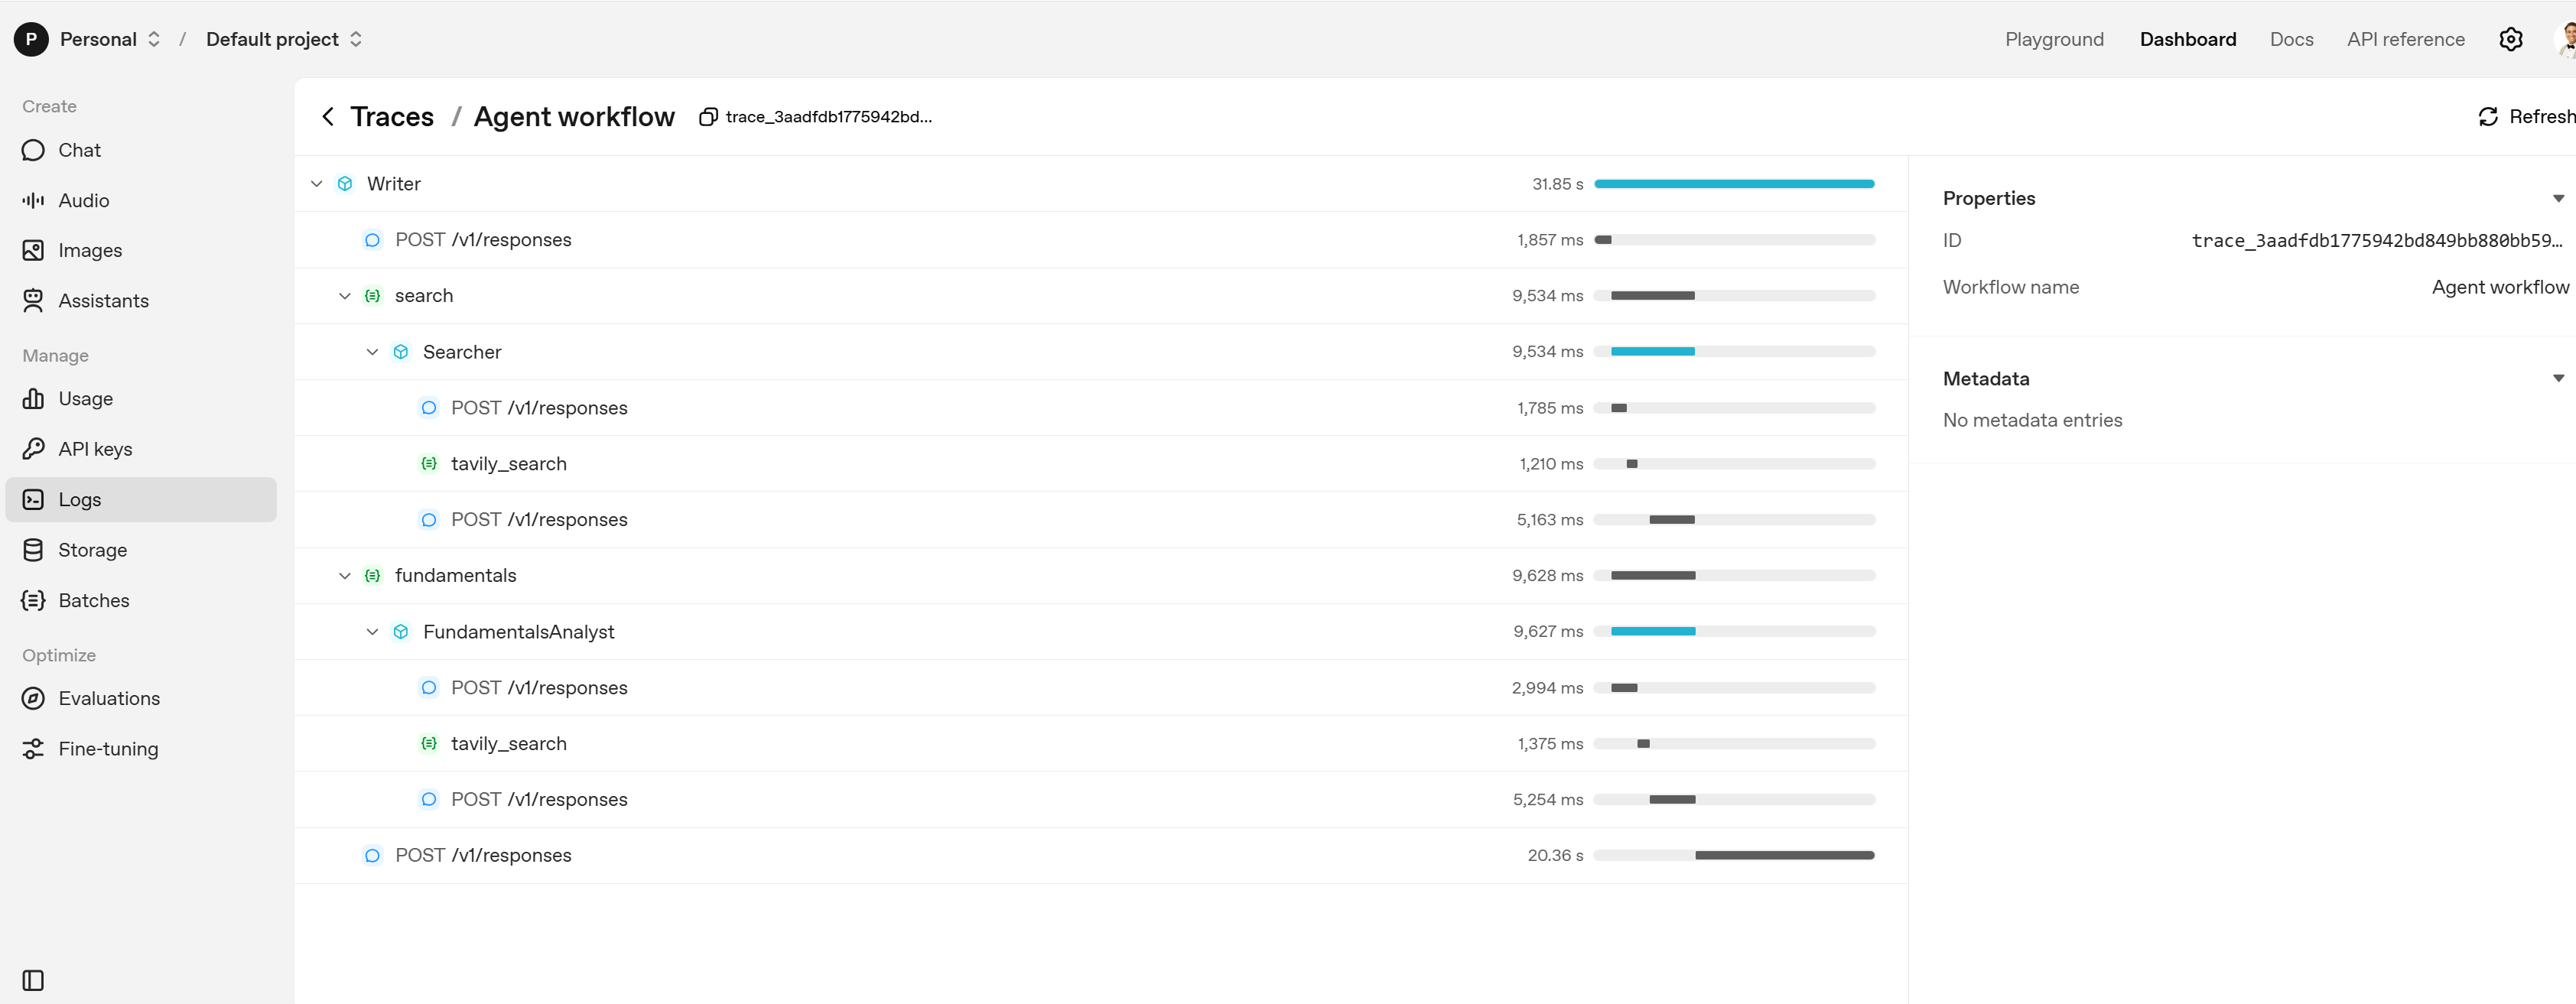

**PRACTICE OPPORTUNITY SOLUTION:**
- **Create a new AI agent named SentimentAgent that specializes in searching online to find out the sentiment regarding a company.**
  - **Update the agent's instructions so that it focuses on analyzing online sentiment (positive, negative, neutral) about the company.**
  - **Use the SentimentAgent agent as a tool for the writer agent we defined earlier.**
  - **Provide an example input (e.g., "What is the current market sentiment about Tesla?").**
  - **Run the agent, analyze the response, and review the traces on OpenAI API Platform**

In [31]:
# Create a session to store the handoff history
session = SQLiteSession("research_agent_handoff_practice_2")


SENTIMENT_PROMPT = """
    Context: You are a sentiment analyst specializing in evaluating online sentiment about companies.
    Instruction: Carefully analyze the provided notes and search online sources to determine the current sentiment (positive, negative, or neutral) regarding the company. Consider recent news, social media, and analyst opinions.
    Input: Notes containing relevant information and search results about the company.
    Output: A concise summary (≤200 words) highlighting the overall sentiment, supporting evidence, and any notable trends or shifts in sentiment.
    Tools: The following tools are available for comprehensive sentiment research on the company:
    - tavily_search: Search the web for information about the company.
    """

sentiment_agent = Agent(
    name = "SentimentAnalyst", 
    instructions = SENTIMENT_PROMPT, 
    output_type = Summary, 
    model = main_model, 
    tools = [tavily_search])


class FinalReport(BaseModel):
    short_summary: str
    markdown_report: str
    follow_up_questions: list[str]


# Define an async extractor function
async def extract_summary(run_result: RunResult) -> str:
    """Extracts the 'summary' field from the final_output of an agent run."""
    return run_result.final_output.summary


writer_agent = Agent(name = "Writer",
                     instructions = (
        """
        Context: You are an expert research writer preparing a comprehensive investment report on a company, using diverse information sources. Your audience is sophisticated and expects clarity, depth, and actionable insights.
        Instruction: Thoroughly analyze the provided search snippets and analyst summaries. Synthesize these into a cohesive, well-structured markdown report of at least 600 words. Your report must: (1) begin with a concise 2-3 sentence executive summary capturing the most critical findings; (2) integrate and cross-reference key facts, trends, and perspectives from all sources, highlighting both consensus and disagreement; (3) organize content with clear headings and logical flow; (4) maintain objectivity, cite evidence, and avoid speculation; (5) conclude with 3-5 insightful, specific follow-up research questions that would meaningfully advance understanding or address unresolved issues. Ensure the writing is precise, professional, and tailored for an investment decision-making context.

        You must always use the 'search' tool to gather and incorporate up-to-date information in your report. The other tools—'fundamentals', 'sentiment'—are optional and should only be used if the user specifically requests those analyses or if you determine that including them would significantly enhance the report's quality or relevance.

        Input: A set of search snippets and analyst summaries containing relevant information about the company, and any user instructions specifying which analyses to include.
        Output: A markdown-formatted report (minimum 600 words) including an executive summary and 3-5 well-crafted follow-up research questions.
        Tools: The following tools are available for comprehensive research on the company:
        - fundamentals: Get fundamentals analysis (optional)
        - search: Get search results (required)
        """
    ),
    model = main_model,
    output_type = FinalReport,
    tools = [
        fundamentals_agent.as_tool(
            "fundamentals",
            "Get fundamentals analysis",
            custom_output_extractor=extract_summary,  # Use the async function here
        ),
        search_agent.as_tool(
            "search",
            "Get search results",
            custom_output_extractor=extract_summary,  # Use the async function here
        ),
        sentiment_agent.as_tool(
            "sentiment",
            "Get sentiment analysis",
            custom_output_extractor=extract_summary,  # Use the async function here
        ),
    ],
)


"""Following is the handoff from Planner to Writer, specifying agent, input type, and callback"""
handoff_to_writer = handoff(
    agent = writer_agent,  # must point to the writer that has the verifier handoff
    input_type = PlannerToWriterInput,
    on_handoff = on_planner_to_writer,
    tool_name_override = "transfer_to_writer",
    tool_description_override = "Transfer to Writer with original query and search plan")

"""Following is the clone of the Planner agent and add handoff instructions and the handoff tool to Writer. 
We are enhancing the prompt to include openai recommended prompt prefix and the handoff tool to the planner agent."""
planner_with_handoff = planner_agent.clone(
    instructions=f"""{RECOMMENDED_PROMPT_PREFIX}\n\n"""
    + planner_agent.instructions
    + "\n\nWhen you have produced the SearchPlan, call the handoff tool `handoff_to_writer` with this JSON input: {{ original_query: <the user query>, search_plan: <the SearchPlan JSON> }}.\n",
    handoffs=[handoff_to_writer],  # Add the handoff to Writer
)

handoff_result = await run_handoffs_demo(
    "Do a deep dive on the latest news and developments in the AAPL stock. Also, I need the fundamentals and sentiment analysis of the company."
)

## 🕵️‍♀️ User Query
Do a deep dive on the latest news and developments in the AAPL stock. Also, I need the fundamentals and sentiment analysis of the company.

➡️ Transfer: Planner → Writer

---

---

### 🔎 Executive Summary
Apple Inc. (AAPL) shows robust financial performance for fiscal 2025, with quarterly revenue up 10% year-over-year and diluted EPS growth of 12%. The stock has faced some volatility, dropping about 5% year-to-date, but retains strong institutional interest and positive analyst sentiment with consensus 'Buy' ratings. Price targets indicate a potential upside, underpinned by solid fundamentals, operational efficiency, and a resilient product demand despite macroeconomic challenges.



-----------------



### 📄 Full Report
# Comprehensive Investment Report on Apple Inc. (AAPL) - August 2025

## Executive Summary
Apple Inc. has demonstrated strong financial fundamentals in fiscal year 2025, with significant year-over-year revenue and EPS growth highlighting operational strength and market demand. While AAPL stock experienced a modest decline of approximately 5% year-to-date amid broader market volatility, institutional investor confidence and bullish analyst ratings suggest positive prospects ahead. This report synthesizes the latest developments, financial metrics, and market sentiment to provide a clear perspective for investment considerations.

## Latest News and Stock Developments
As of August 2025, Apple’s stock price hovers around $231.59, reflecting a 5% decline year-to-date. Despite the dip, institutional investors continue to see value in Apple, with ongoing purchases of tech stocks indicative of confidence in the sector. Notably, Berkshire Hathaway has reduced its stake, signaling some repositioning among large shareholders, which warrants watchfulness for future moves. The company recently paid dividends in mid-August 2025, reflecting a continued commitment to returning value to shareholders. Analyst price targets remain optimistic, with firms like Wedbush projecting $270 and JP Morgan $255, indicating expectations for sustained growth and stock recovery potential.

## Fundamental Financial Performance
Apple’s fiscal 2025 third-quarter results showcase strong momentum:

- **Revenue:** $94.0 billion in Q3, a 10% year-over-year increase.
- **Diluted Earnings Per Share (EPS):** $1.57, rising 12% annually.
- **Full Year Revenue (to date):** Approximately $117.2 billion.
- **Gross Profit:** Around $50.3 billion, highlighting robust margins.
- **Operating Income:** $36 billion.
- **Pre-Tax Income:** Approximately $35.6 billion.

These figures underscore Apple’s ability to maintain healthy profit margins while scaling revenue. The uptick in EPS reflects both revenue growth and operational efficiency. Steady demand for its diverse product ecosystem and services plays a crucial role in this financial robustness.

## Market Sentiment and Analyst Perspectives
Market sentiment for Apple stock remains broadly positive. Analysts predominantly rate AAPL as a "Buy," with price targets averaging between $237 and $247, suggesting an upside potential ranging roughly from 2.35% to 22.63% over the next year. Financial powerhouses such as Barclays, JP Morgan, Morgan Stanley, and Bank of America Securities have issued favorable ratings and price targets, reaffirming confidence in Apple's growth trajectory.

Despite some headwinds from regulatory scrutiny, the overall analyst community views Apple’s steady revenue growth and EPS forecasts as underpinning a resilient investment case. Social and market sentiment indicators align with this bullish outlook, reflecting strong investor confidence amid macroeconomic uncertainties.

## Synthesis and Strategic Considerations
The convergence of strong fundamentals and positive analyst sentiment places Apple in a solid position for potential appreciation in stock value, despite recent volatility. Key considerations include:

- **Institutional Activity:** Continued buying by major investors suggests confidence, though shifts such as Berkshire Hathaway’s stake reduction warrant monitoring.
- **Growth Trajectory:** Revenue and EPS growth at double-digit rates exemplify operational strength.
- **Valuation and Price Targets:** The consensus leans towards undervaluation at current prices, with substantial upside indicated by analyst targets.
- **Dividend Policy:** Consistent dividend payments enhance shareholder returns, adding to investment appeal.

## Conclusion
Apple remains a fundamentally strong and well-regarded technology giant with ample growth and value potential. The balance of solid earnings growth, positive market and analyst sentiment, and institutional backing provide a compelling investment narrative. Investors should, however, remain attentive to ownership shifts and regulatory challenges.

## Follow-Up Research Questions
1. How are recent shifts in large institutional ownership, particularly by Berkshire Hathaway, influencing Apple’s stock liquidity and price dynamics?
2. What are the potential impacts of current and future regulatory scrutiny on Apple’s product ecosystem and service revenues?
3. How sustainable is the current revenue and EPS growth trajectory in light of emerging competitive pressures and macroeconomic conditions?
4. What are the projections and strategic initiatives related to Apple's innovation pipeline, particularly in new product categories?
5. How do dividend policies and share repurchase programs factor into the long-term shareholder return strategy?

---

*This report integrates the latest financial, market, and sentiment data to provide a comprehensive view tailored for informed investment decision-making.*



-----------------



- **Would love to connect with everyone on LinkedIn: www.linkedin.com/in/dr-ryan-ahmed**

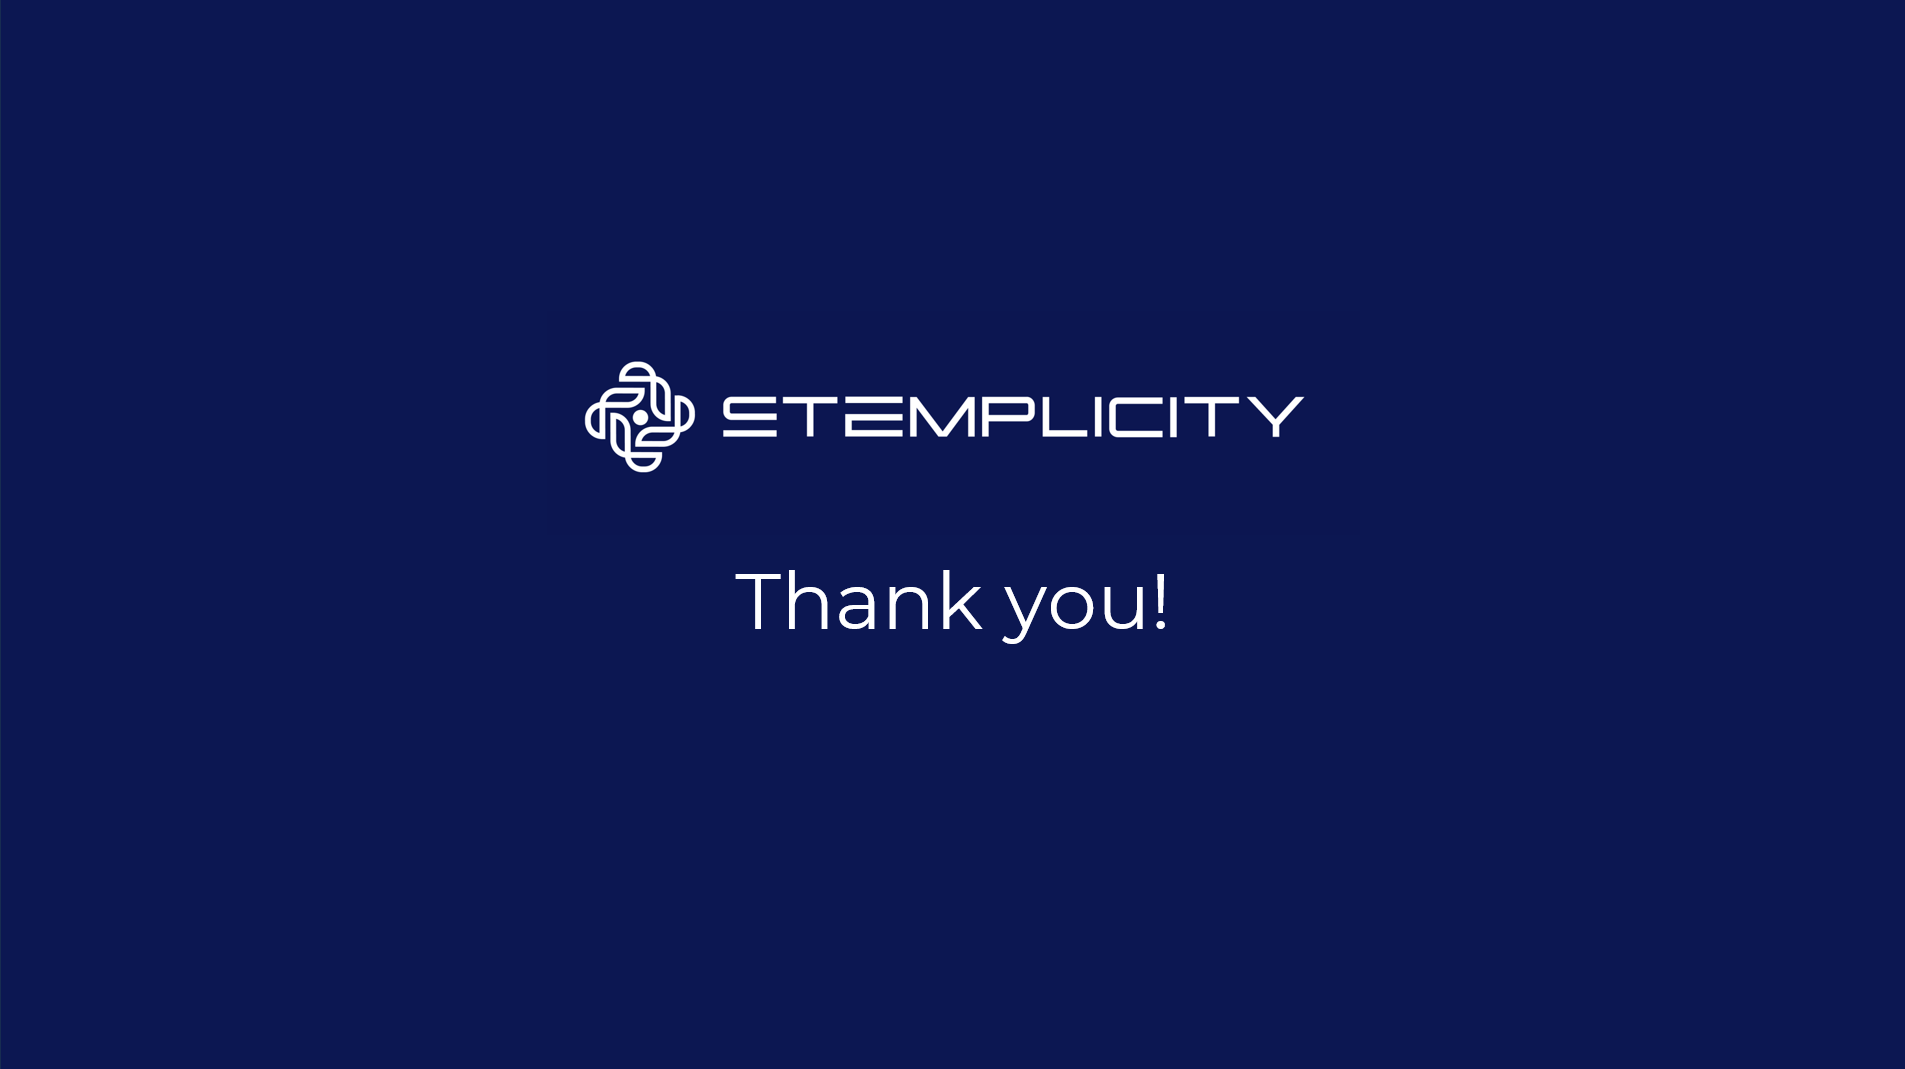